### imports and start

In [ ]:
from collections import defaultdict
from pathlib import Path
import json
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# \definecolor{default}{rgb}{0.3137254901960784,0.4627450980392157,0.6588235294117647}
# \definecolor{hidden}{rgb}{0.8,0.5372549019607843,0.38823529411764707}
# \definecolor{concat}{rgb}{0.2784313725490196,0.6274509803921569,0.4117647058823529}
# \definecolor{crssm}{rgb}{0.7607843137254902,0.3411764705882353,0.3686274509803922}
# \definecolor{ep}{rgb}{0.16470588235294117,0.6666666666666666,0.3803921568627451}
# \definecolor{rp}{rgb}{0.39215686274509803,0.7098039215686275,0.803921568627451}"

COLOR_MAP = {
    "cRSSM": (0.7607843137254902,0.3411764705882353,0.3686274509803922),
    "Hidden Context": (0.8, 0.5372549019607843, 0.38823529411764707),
    "Concat Context": (0.2784313725490196,0.6274509803921569,0.4117647058823529),
    "Default Context": (0.3137254901960784,0.4627450980392157,0.6588235294117647),
}


In [ ]:

score_types = ["median", "IQM", "mean", "Optimality Gap"]
TASK_MAP = { "classic_cartpole": "Cartpole",
            "dmc_walker":"dmc Walker"}
TYPE_MAP = {'Interp': 'Interpolate', 'Extrap': 'Extrapolate', 'Inter_Extra': 'Single Factor Extrapolate'}

CTX_ALG_MAP = {"no_ctx_default": "Default Context",
           "no_ctx": "Hidden Context",
            "enc_dec_ctx": "Concat Context",
            "pgm_ctx": "cRSSM",
            #"pgm_ctx_adv": "vRSSM"
           }
#"featurized" if modality == "obs" else "pixel"
MODALITY_MAP = {"obs": "Featurized",
                "vector": "Featurized",
                "img": "Pixel",
                "pixel": "Pixel"}

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def get_expert_and_random_metrics():
    expert_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    random_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    specific_exp_dir = Path("../logs/specific")
    for exp_dir in specific_exp_dir.iterdir():

        expert_returns = []
        random_returns = []
        for seed_dir in exp_dir.iterdir():
            if (seed_dir / "eval.jsonl").exists():
                metrics = json.loads((seed_dir / "eval.jsonl").read_text().split("\n")[0])
                expert_returns.append(metrics["return"])
            if (seed_dir / "eval_random_policy.jsonl").exists():
                metrics = json.loads((seed_dir / "eval_random_policy.jsonl").read_text().split("\n")[0])
                random_returns.append(metrics["return"])
        if len(expert_returns) == 0:
            continue
        task = None
        for k in expert_agent_metrics:
            if k in exp_dir.name:
                task = k
                break
        
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        
        ctx_k_v_str = exp_dir.name.split("specific_")[1].split("_enc")[0]
        
        ctx_val = [default_0, default_1]
        for k_v in ctx_k_v_str.split("_"):
            k, v = k_v.split("-")
            v = float(v)
            k = int(k)
            ctx_val[int(k)] = v
        expert_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(expert_returns)
        random_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(random_returns)
    return expert_agent_metrics, random_agent_metrics

In [ ]:
expert_agent_metrics, random_agent_metrics = get_expert_and_random_metrics()

In [ ]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
tasks = ["classic_cartpole", "dmc_walker"]
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")


In [ ]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
from scipy.stats import sem

## RLiable Evals


### helpers

In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [ ]:
#compute scores function 
# aggregate_func = lambda x: np.array([
#   metrics.aggregate_median(x),
#   metrics.aggregate_iqm(x),
#   metrics.aggregate_mean(x),
#   metrics.aggregate_optimality_gap(x)])

metrics_agg_map = {'Median': metrics.aggregate_median,
                    'IQM': metrics.aggregate_iqm,
                    'Mean': metrics.aggregate_mean,
                    'Optimality Gap': metrics.aggregate_optimality_gap}

In [ ]:
def compute_scs(score, target_metrics=["IQM",]):
    """
    
    """


    if score.shape[0] != 0:
        #create aggregate_func 
        aggregate_func = lambda x: np.array([
            metrics_agg_map[metric](x)
            for metric in target_metrics])


        #aggregate using rliable
        score = score.transpose() #(num_runs, num_contexts)
        score = {"test": score}
        aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
            score, aggregate_func, reps=1000)
        aggregate_scores = {target_metrics[i]: aggregate_scores['test'][i] for i in range(len(target_metrics))}
        aggregate_score_cis = {target_metrics[i]: aggregate_score_cis['test'][:,i] for i in range(len(target_metrics))}
        return aggregate_scores, aggregate_score_cis
    return {key: None for key in target_metrics}, {key: None for key in target_metrics}


def compute_scs_all(score, target_metrics=['IQM', 'Optimality Gap']):
    """
    
    """
    aggregate_func = lambda x: np.array([
            metrics_agg_map[metric](x)
            for metric in target_metrics])
    
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score, aggregate_func, reps=100)
    return aggregate_scores, aggregate_score_cis

In [ ]:

def compute_IP(score_pairs, reps=100):
    """
    """
    print('current_score_pairs shapes: ')
    min_ovral = 100000
    score_pairs_processed = {}
    for k, v in score_pairs.items():
        #resample v to the min shape
        v = (v[0].T, v[1].T)
        min_shape = min(v[0].shape[0], v[1].shape[0])
        score_pairs_processed[k] = (v[0][:min_shape], v[1][:min_shape])

    probabilities, probability_cis = {}, {}
    
    probabilities, probability_cis = rly.get_interval_estimates(
        score_pairs_processed, metrics.probability_of_improvement, reps=reps)
    return probabilities, probability_cis


def compute_IP_NOT(score_pairs, reps=100):
    """
    """
    #print('current_score_pairs shapes: ')
    min_ovral = 100000
    score_pairs_processed = score_pairs
    #print(score_pairs)
    # for k, v in score_pairs.items():
    #     #resample v to the min shape
        
    #     min_shape = min(v[0].shape[0], v[1].shape[0])
    #     score_pairs_processed[k] = (v[0][:min_shape], v[1][:min_shape])

    probabilities, probability_cis = {}, {}
    probabilities, probability_cis = rly.get_interval_estimates(
        score_pairs_processed, metrics.probability_of_improvement, reps=reps)
    return probabilities, probability_cis

In [ ]:
def match_and_normalize_metrics(agent_metrics, expert_metrics, random_metrics):
    normalized_metrics = {}
    min_ctx_0 = min([k[0] for k in agent_metrics])
    max_ctx_0 = max([k[0] for k in agent_metrics])
    min_ctx_1 = min([k[1] for k in agent_metrics])
    max_ctx_1 = max([k[1] for k in agent_metrics])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in expert_metrics
    ]
    best_keys = list(expert_metrics.keys())
    
    for current_key, returns in agent_metrics.items():
        normalized_current_key = ((current_key[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (current_key[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_current_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        nearest_best_return = expert_metrics[nearest_key]
        #print("returns shape:", returns.shape)
        #print(random_metrics[nearest_key])
        #print("random metrics shape:", len(random_metrics[current_key]))
        normalized_metrics[current_key] = (returns - random_metrics[nearest_key]) / (nearest_best_return - random_metrics[nearest_key])
    return normalized_metrics

### Compute summary metrics fun

In [ ]:
def compute_summary_metric(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, random_agent_metrics, t_step="50k", required_metrics=["IQM",]):
    assert train_setting in ["default", "single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]

    
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{t_step}"
    elif ctx_type == "pgm_ctx_adv":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{t_step}"
    else:
        raise RuntimeError("invalid ctx")
    if not exp_path.exists():
        print("Path does not exist")
        return None

    ctx_type = CTX_ALG_MAP[ctx_type]
    modality = MODALITY_MAP[modality]
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        if len(lines) != 84:
            continue
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or (train_setting == "default" and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.array(v) for k, v in current_metrics.items()}
    normalized_score = {}
    best_metrics = best_agent_metrics[task]
    random_metrics = random_agent_metrics[task]
    normalized_score = match_and_normalize_metrics(agent_metrics, best_metrics, random_metrics)
    #print(normalized_score)
    interpolate_ranges = [
        [default_0 - 1e-6, default_0 + 1e-6],
        [default_1 - 1e-6, default_1 + 1e-6]
    ]
    if context_idx is not None:
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    else:
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    
    
    interpolate_score = []
    extrapolate_score = []
    inter_extrapolate_score = []
    
    for ctx_key in normalized_score:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            if normalized_score:
                interpolate_score.append(normalized_score[ctx_key])
 
        elif context_idx is not None or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            if normalized_score:
                extrapolate_score.append(normalized_score[ctx_key])

        else:
            if normalized_score:
                inter_extrapolate_score.append(normalized_score[ctx_key])

    interpolate_score = np.array(interpolate_score)
    extrapolate_score = np.array(extrapolate_score)
    inter_extrapolate_score = np.array(inter_extrapolate_score)

    #use compute_scs to aggregate
    interpolate_score, interpolate_cis = compute_scs(interpolate_score, required_metrics) 
    extrapolate_score, extrapolate_cis = compute_scs(extrapolate_score, required_metrics)
    inter_extrapolate_score, inter_extra_cis = compute_scs(inter_extrapolate_score, required_metrics)
    task = TASK_MAP[task]
    
    context_name = metric_context_name or f'{ctx_0},{ctx_1}'
    #replace _ with space and capitalize first letters
    context_name = context_name.replace("_", " ").title()
    
    return {'Task':task,
            'Train Setting':train_setting,
            'Context':context_name,
            'Modality':modality,
            'Inputs': ctx_type,
            **{f'Interp_{key}' : round(val,3) if val is not None else val for key, val in interpolate_score.items() },
            **{f'Extrap_{key}' : round(val,3) if val is not None else val for key, val in extrapolate_score.items()},
            **{f'Inter_Extra_{key}' : round(val,3) if val is not None else val for key, val in inter_extrapolate_score.items()},
            **{f'Interp_{key}_ci' : np.round(val,3) if val is not None else val for key, val in interpolate_cis.items()},
            **{f'Extrap_{key}_ci' :  np.round(val,3) if val is not None else val for key, val in extrapolate_cis.items()},
            **{f'Inter_Extra_{key}_ci' : np.round(val,3) if val is not None else val for key, val in inter_extra_cis.items()},
    }
    

### Get IES score func

In [ ]:
def get_ies_scores(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, random_agent_metrics, t_step="50k"):
    assert train_setting in ["single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    #print('IN ies')
    #print(ctx_type, task, train_setting_full, modality, t_step)

    if ctx_type == "no_ctx_default":
        exp_path = log_dir / f"carl_{task}_{'default'}_enc_{modality}_dec_{modality}_{t_step}"
    elif ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{t_step}"
    # elif ctx_type == "pgm_ctx_adv":
    #     exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{t_step}"
    #     ctx_type = "d-cRSSM"
    else:
        raise RuntimeError("invalid ctx")
    
    
    
    if not exp_path.exists():
        print("Path does not exist")
        return None

    ctx_type = CTX_ALG_MAP[ctx_type]
    #modality = "featurized" if modality == "obs" else "pixel"
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        if len(lines) != 84:
            continue
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or ("default" in ctx_type.lower() and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.array(v) for k, v in current_metrics.items()}
    normalized_score = {}
    best_metrics = best_agent_metrics[task]
    random_metrics = random_agent_metrics[task]
    normalized_score = match_and_normalize_metrics(agent_metrics, best_metrics, random_metrics)
    #print(normalized_score)
    interpolate_ranges = [
        [default_0 - 1e-6, default_0 + 1e-6],
        [default_1 - 1e-6, default_1 + 1e-6]
    ]
    if context_idx is not None:
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    else:
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    
    
    interpolate_score = []
    extrapolate_score = []
    inter_extrapolate_score = []
    
    for ctx_key in normalized_score:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            if normalized_score:
                interpolate_score.append(normalized_score[ctx_key])
 
        elif context_idx is not None or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            if normalized_score:
                extrapolate_score.append(normalized_score[ctx_key])

        else:
            if normalized_score:
                inter_extrapolate_score.append(normalized_score[ctx_key])

    interpolate_score = np.array(interpolate_score)
    extrapolate_score = np.array(extrapolate_score)
    inter_extrapolate_score = np.array(inter_extrapolate_score)
    return interpolate_score, extrapolate_score, inter_extrapolate_score

### compute IP func

In [ ]:
def compute_IP_metric(log_dir, task, train_setting, context_idx, modality, best_agent_metrics, random_agent_metrics, t_step="50k", our_algorithm = "pgm_ctx", algorithms = ["no_ctx_default", "no_ctx", "enc_dec_ctx", "pgm_ctx"], types=["Interp", "Extrap", "Inter_Extra"]):
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]

    metric_context_name = None
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    
    scores_per_alg = defaultdict(dict)
    for alg in algorithms:
        interpolate_score, extrapolate_score, inter_extrapolate_score = get_ies_scores(log_dir, task, train_setting, context_idx, modality, alg, best_agent_metrics, random_agent_metrics, t_step)
        scores_per_alg[alg] = {'Interp': interpolate_score, "Extrap":extrapolate_score, "Inter_Extra":inter_extrapolate_score}
    
    #get IP scores
    ip_scores = {}
    for type in types:
        #print(type)
        all_pairs = {}
        for alg in (algorithms):
            if alg == our_algorithm:
                continue
            pair_name = f'{our_algorithm}_{alg}'
            our_alg, rival_alg = scores_per_alg[our_algorithm][type], scores_per_alg[alg][type]
            #check if both score are not None
            if our_alg.size != 0 and rival_alg.size != 0:
                all_pairs[pair_name] = (
                    scores_per_alg[our_algorithm][type], scores_per_alg[alg][type]) 

        probabilities, probability_cis = compute_IP(all_pairs)
        ip_scores[type] = (probabilities, probability_cis)
        #print(ip_scores[type])

    #use compute_scs to aggregate
    interpolate_score, interpolate_cis = ip_scores["Interp"]
    extrapolate_score, extrapolate_cis = ip_scores["Extrap"]
    inter_extrapolate_score, inter_extra_cis = ip_scores["Inter_Extra"]
    
    task = TASK_MAP[task]
        
    return {'Task':task,
            'Train Setting':train_setting,
            'Context':metric_context_name or f'{ctx_0},{ctx_1}',
            'Modality':modality,
            'Interp_IP' : interpolate_score if interpolate_score is not None else interpolate_score ,
            f'Extrap_IP' : extrapolate_score if extrapolate_score is not None else extrapolate_score,
            f'Inter_Extra_IP' : inter_extrapolate_score if inter_extrapolate_score is not None else inter_extrapolate_score,
            f'Interp_IP_ci' : interpolate_cis if interpolate_cis is not None else interpolate_cis,
            f'Extrap_IP_ci' :  extrapolate_cis if extrapolate_cis is not None else extrapolate_cis,
            f'Inter_Extra_IP_ci' : inter_extra_cis if inter_extra_cis is not None else inter_extra_cis,
    }
    

### Aggregate all func

In [ ]:
def compute_agg_all(log_dir,
                    tasks,
                    train_settings,
                    modality,
                    best_agent_metrics,
                    random_agent_metrics,
                    t_step="normalized",
                    our_algorithm = "pgm_ctx",
                    algorithms =  ["no_ctx_default", "no_ctx", "enc_dec_ctx", "pgm_ctx"], #, "pgm_ctx_adv"]
                    target_metrics=["IQM",],
                    types = ["Interp", "Extrap", "Inter_Extra"]):

    scores_per_alg = defaultdict(lambda: defaultdict(list))
    for task in tasks:
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        for setting in train_settings:
            if setting == "single":
                context_ids = [0, 1]
            else:
                context_ids = [None]
            for ctx_id in context_ids:
                metric_context_name = None
                if ctx_id is not None:
                    metric_context_name = _TASK2CONTEXTS[task][ctx_id]["context"]
    
                for alg in algorithms:    
                    #print('getting results for algorithm:', alg, 'task:', task, 'setting:', setting, 'context:', ctx_id, 'modality:', modality)
                    #interpolate_score, extrapolate_score, inter_extrapolate_score = get_ies_scores(log_dir, task, setting, ctx_id, modality, alg, best_agent_metrics, random_agent_metrics, t_step=t_step)
                    #print('shapes are:', interpolate_score.shape, extrapolate_score.shape, inter_extrapolate_score.shape)
                    type_scores = get_ies_scores(log_dir, task, setting, ctx_id, modality, alg, best_agent_metrics, random_agent_metrics, t_step=t_step)
                    
                    #type_scores = [interpolate_score, extrapolate_score, inter_extrapolate_score]
                    # scores_per_alg['Interp'][alg].append(interpolate_score)
                    # scores_per_alg['Extrap'][alg].append(extrapolate_score)
                    # scores_per_alg['Inter_Extra'][alg].append(inter_extrapolate_score)
                    for i, type in enumerate(types):
                        scores_per_alg[type][ CTX_ALG_MAP[alg]].append(type_scores[i])
    
    algorithms = [CTX_ALG_MAP[alg] for alg in algorithms]
    for alg in algorithms:
        for type in types:
            #drop seed before last
            score_list = [np.delete(scores, 8, axis=1) if scores.shape[1] == 10 else scores for scores in scores_per_alg[type][alg] if scores.size != 0] #np.delete(scores, 8, axis=1) if scores.shape[1] == 10 else scores scores[:,:9]
            #print([scores.shape for scores in score_list])
            scores_per_alg[type][alg] = np.concatenate(score_list, axis=0).T
            print(alg, type, scores_per_alg[type][alg].shape)
    
    # for k, v in scores_per_alg.items():
    #     print("Type is: ", k)
    #     for k2, v2 in v.items():
    #         print("Alg and shape")
    #         print(k2, v2.shape)
    #current shapes are 
    #asame loop again


    

    our_algorithm = CTX_ALG_MAP[our_algorithm]
    # #get IP scores
    ip_scores = {}
    for type in types:
        #print(type)
        all_pairs = {}
        for alg in (algorithms):
            if alg == our_algorithm:
                continue
            pair_name = f'{our_algorithm}_{alg}'
            our_alg, rival_alg = scores_per_alg[type][our_algorithm], scores_per_alg[type][alg]
            #print(len(our_alg), len(rival_alg))

            #check if both score are not None
            #print(our_alg.shape, rival_alg.shape)
            if our_alg.size != 0 and rival_alg.size != 0:
                all_pairs[pair_name] = (
                    our_alg, rival_alg) 

        probabilities, probability_cis = compute_IP_NOT(all_pairs)
        ip_scores[type] = (probabilities, probability_cis)
        
    # get all the scores
    all_interpolate_score, all_interpolate_cis = compute_scs_all(scores_per_alg['Interp'], target_metrics=target_metrics) 
    all_extrapolate_score, all_extrapolate_cis = compute_scs_all(scores_per_alg['Extrap'], target_metrics= target_metrics)
    all_inter_extrapolate_score, all_inter_extra_cis = compute_scs_all(scores_per_alg['Inter_Extra'], target_metrics= target_metrics)
    #print(all_interpolate_score, all_interpolate_cis)
    #get all_interp_score_dict 
    final_scores_dict = defaultdict(dict)
    #return a dataframe, a row for each algorithm
    for alg in algorithms:
        for i, metric in enumerate(target_metrics):
            final_scores_dict[alg][f'Interp_{metric}'] = np.round(all_interpolate_score[alg][i],3)
            final_scores_dict[alg][f'Extrap_{metric}'] = np.round(all_extrapolate_score[alg][i],3)
            final_scores_dict[alg][f'Inter_Extra_{metric}'] = np.round(all_inter_extrapolate_score[alg][i],3)
            final_scores_dict[alg][f'Interp_{metric}_ci'] = np.round(all_interpolate_cis[alg][:,i].flatten(),3)
            final_scores_dict[alg][f'Extrap_{metric}_ci'] = np.round(all_extrapolate_cis[alg][:,i].flatten(),3)
            final_scores_dict[alg][f'Inter_Extra_{metric}_ci'] = np.round(all_inter_extra_cis[alg][:,i].flatten(),3)
            #shape of cis is (2, num_metrics)

            for type, val in ip_scores.items():
                if our_algorithm != alg:
                    final_scores_dict[alg][f'{type}_IP'] = np.round(val[0][f'{our_algorithm}_{alg}'],3)
                    final_scores_dict[alg][f'{type}_IP_ci'] = np.round(val[1][f'{our_algorithm}_{alg}'].flatten(),3)

    #create a dataframe with rows as algorithms
    df = pd.DataFrame(final_scores_dict).T
    return df

## Computing scores

In [ ]:
expert_agent_metrics, random_agent_metrics = get_expert_and_random_metrics()

### without agg

In [ ]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
score_names = ["i_score", "e_score", "ie_score"]
logdir = Path("../logs")
save_dir = Path("./plots/")
best = 8

required_metrics = ["IQM", "Optimality Gap"]
df_list = []
import warnings
for task in tasks:
    for setting in ["single", "double_box"]:
        if setting == "single":
            context_ids = [0, 1]
        else:
            context_ids = [None]
        for ctx_id in context_ids:
            for modality in modalities:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    row = compute_summary_metric(logdir, task, "default", ctx_id, modality, "no_ctx", expert_agent_metrics, random_agent_metrics, "normalized", required_metrics=required_metrics)
                    #if row:
                    # row_details, scores = row[:-3], row[-3:]
                    # #loop over returned scores and add to df
                    # scores = tuple([compute_scs(score) for score in scores])
                    # print("scores are:", scores)
                    #df.loc[len(df)] = row #row_details + scores
                    df_list.append(row)
                    for ctx_type in ["no_ctx", "enc_dec_ctx", "pgm_ctx",]: # "pgm_ctx_adv"
                        row = compute_summary_metric(logdir, task, setting, ctx_id, modality, ctx_type, expert_agent_metrics, random_agent_metrics, "normalized", required_metrics)
                        # row_details, scores = row[:-3], row[-3:]
                        # scores = tuple([compute_scs(score) for score in scores])
                        #df.loc[len(df)] = row #row_details + scores
                        df_list.append(row)

In [ ]:
df = pd.DataFrame(df_list)

In [ ]:
df.head()

In [ ]:
df = pd.DataFrame(df_list)
df.to_csv("RLIBLE_METRICS.csv")

### With agg

In [ ]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
score_names = ["i_score", "e_score", "ie_score"]
logdir = Path("../logs")
save_dir = Path("./plots/")
best = 8

required_metrics = ["IQM", "Optimality Gap"]
df_list = []
import warnings

for modality in modalities:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = compute_agg_all(logdir, tasks, train_settings, modality, expert_agent_metrics, random_agent_metrics, "normalized", our_algorithm = "pgm_ctx", algorithms = ["no_ctx_default", "no_ctx", "enc_dec_ctx", "pgm_ctx"], target_metrics=required_metrics)
        df['modality'] = MODALITY_MAP[modality]
        df_list.append(df)
    #break

df_agg = pd.concat(df_list)

#algorithm_map = {'no_ctx': 'No Context', 'no_ctx_default': 'No Context Default', 'enc_dec_ctx': 'Concat Context', 'pgm_ctx': 'cRSSM'}
#df = df.rename(index=ALOGORITHM_MAP)
df_agg.to_csv("RLIB_AGG.csv")

## Plot of the RLiable Evals

### load and fix

In [ ]:
#load csv "summary_metrics_final_x.csv"
df = pd.read_csv("RLIBLE_METRICS.csv", index_col=0)
df.loc[df['Train Setting']=='default', 'Inputs'] = 'No Context Default'

In [ ]:
df.head()
# change 'no context' Input to 'No Context'
#change 'no context (default)' to 'No Context (default)'
#df.loc[df['Inputs']=='no context', 'Inputs'] = 'No Context'
#df.loc[df['Inputs']=='no context (default)', 'Inputs'] = 'No Context Default'
#drop rows with Inputs == d-cRSSM
#df = df[df['Inputs'] != 'd-cRSSM']


In [ ]:
df.head()    

### Helpers for plotting

In [ ]:
def convert_to_lst(s):
    s = s.strip('[]')  # Remove the brackets
    list_num = list(map(float, s.split()))
    return list_num

def create_scores_from_df(df, type, metrics = ['IQM', 'Optimality Gap'], types = ['Interp', 'Extrap', 'Inter_Extra']):
    aggregate_scores, aggregate_score_cis = defaultdict(list), defaultdict(list)
    algorithms = df['Inputs'].unique()
    #get task from the first row and column Task 
    aggregate_scores, aggregate_score_cis = defaultdict(list), defaultdict(list)
    for algorithm in algorithms:
        for i in range(len(metrics)):
            val = df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}'].values[0]
            #check if val is NaN
            if val != val:
                #print('skipping')
                continue
            #print(df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}_ci'].shape)
            aggregate_scores[algorithm].append(df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}'].values[0])
            c_ci = df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}_ci'].values[0]
            c_ci = convert_to_lst(c_ci) if isinstance(c_ci, str) else c_ci
            aggregate_score_cis[algorithm].append(c_ci)
        if val != val:
            continue
        aggregate_scores[algorithm] = np.array(aggregate_scores[algorithm])
        aggregate_score_cis[algorithm] = np.array(aggregate_score_cis[algorithm]).transpose()
        # for k, v in aggregate_scores.items():
        #     print(k, v.shape)
        #     print(aggregate_score_cis[k].shape)
    return aggregate_scores, aggregate_score_cis

In [ ]:
import os

In [ ]:
cp = sns.color_palette(n_colors=4)

In [ ]:
COLOR_MAP['Default Context'] = cp[0]
COLOR_MAP['cRSSM'] = cp[-1]
COLOR_MAP['Hidden Context'] = cp[1]
COLOR_MAP['Concat Context'] = cp[2]

In [ ]:
sns.color_palette("colorblind", 5)[1]

In [ ]:
def compare_plot_algorithms(df, target_dir = 'rlible_plots_dropv', metrics = ['IQM', 'Optimality Gap'], types = ['Interp', 'Extrap', 'Inter_Extra'], remove_labels = False):
    aggregate_scores, aggregate_score_cis = defaultdict(list), defaultdict(list)
    algorithms = df['Inputs'].unique()
    #get task from the first row and column Task 
    task = df['Task'].values[0] if 'Task' in df.columns else "Aggregated"
    train_settings = df['Train Setting'].values[-1] if 'Train Setting' in df.columns else ""
    Context	= df['Context'].values[0].capitalize() if 'Context' in df.columns else ""
    Context = Context.replace("_", " ").title()
    modality = df['Modality'].values[0] if 'Modality' in df.columns else df['modality'].values[0]

    #captizalize first letter only
    modality = modality.capitalize()
    if train_settings!= '':
        train_settings = 'Single' if train_settings.lower() == 'single' else 'Double'


    
    for type in types:
        aggregate_scores, aggregate_score_cis = create_scores_from_df(df, type, metrics=metrics)
        
        title_fig = f'{task} - {TYPE_MAP[type]} - {modality}'
        title_fig = f'{title_fig} - {train_settings}' if train_settings != '' else title_fig
        title_fig = f'{title_fig} - {Context}' if Context != '' else title_fig
        if len(aggregate_scores.keys()):
            fig, axes = plot_utils.plot_interval_estimates(
                aggregate_scores, aggregate_score_cis,
                metric_names=metrics,
                colors=COLOR_MAP,
                algorithms=list(aggregate_scores.keys()),
                row_height = 0.5, subfigure_width= 9, xlabel=title_fig if not remove_labels else "", xlabel_y_coordinate=-0.3)
                # add extra title to the fig at the bottom
                #fig.suptitle(f'{task} - {type} - {modality} - {train_settings} - {Context}', y=-0.8, fontsize=22)
                
            plt.show()
            # save the fig to direct rlible_plots
            os.makedirs(target_dir, exist_ok=True)
            #save as pdf
            fig.savefig(f'{target_dir}/{title_fig}.pdf', bbox_inches='tight')



In [ ]:
import os
aspect_ratio = 16/9
figure_width = 5.5 # inches

def plot(df, target_dir = 'rlible_plots_dropv', metrics = ['IQM', 'Optimality Gap'], types = ['Interp', 'Extrap', 'Inter_Extra'], remove_labels = False):
    
    
    subfigure_width = 6  
    row_height = subfigure_width / 3 / 2.5

    
    aggregate_scores, aggregate_score_cis = defaultdict(list), defaultdict(list)
    algorithms = df['Inputs'].unique()
    #get task from the first row and column Task 
    task = df['Task'].values[0] if 'Task' in df.columns else "Aggregated"
    train_settings = df['Train Setting'].values[-1] if 'Train Setting' in df.columns else ""
    Context	= df['Context'].values[0].capitalize() if 'Context' in df.columns else ""
    Context = Context.replace("_", " ").title()
    modality = df['Modality'].values[0] if 'Modality' in df.columns else df['modality'].values[0]

    #captizalize first letter only
    modality = modality.capitalize()
    if train_settings!= '':
        train_settings = 'Single' if train_settings.lower() == 'single' else 'Double'


    aggregate_scores_type = {type: create_scores_from_df(df, type, metrics=metrics)[0] for type in types}
    aggregate_score_cis_type = {type: create_scores_from_df(df, type, metrics=metrics)[1] for type in types}
    
    aggregate_scores = {alg: np.concatenate([ aggregate_scores_type[type][alg] for type in types]) for alg in algorithms}
    aggregate_score_cis = {alg: np.concatenate([ aggregate_score_cis_type[type][alg] for type in types], axis = -1) for alg in algorithms}
    
    print(aggregate_scores)
    print(aggregate_score_cis)
    title_fig = f'{task} - {modality}'
    title_fig = f'{title_fig} - {train_settings}' if train_settings != '' else title_fig
    title_fig = f'{title_fig} - {Context}' if Context != '' else title_fig
    if len(aggregate_scores.keys()):
        fig, axes = plot_utils.plot_interval_estimates(
            aggregate_scores, aggregate_score_cis,
            colors=COLOR_MAP,
            metric_names=['Interpolate', 'Extrapolate', 'Single Factor Extrapolate'],
            algorithms=list(aggregate_scores.keys()),
            row_height = row_height,
            subfigure_width= subfigure_width,

            xlabel=title_fig if not remove_labels else "", xlabel_y_coordinate=-0.3)
            # add extra title to the fig at the bottom
            #fig.suptitle(f'{task} - {type} - {modality} - {train_settings} - {Context}', y=-0.8, fontsize=22)
        #update font size for labels
        fontsize_neurips = 12
        for ax in axes:
            ax.set_xlabel(ax.get_xlabel(), fontsize=12)
            ax.set_ylabel(ax.get_ylabel(), fontsize=12)
        plt.show()
        # save the fig to direct rlible_plots
        os.makedirs(target_dir, exist_ok=True)
        #save as pdf
        fig.savefig(f'{target_dir}/{title_fig}.pdf', bbox_inches='tight')



### plot all 

In [ ]:
# loop for each five rows and use plot compare_plot_algorithms for each
for name, subframe in df.groupby(np.arange(len(df)) // 4):
    #print(name)
    #print(group.head())
    compare_plot_algorithms(subframe, target_dir='test_rlible_plots')

### Plot aggregate

In [ ]:
#modality_map = {'obs': 'Featurized', 'img': 'Pixel'}
df_agg = df_agg.rename_axis('Inputs').reset_index()

In [ ]:
df_agg.head()

In [ ]:
#rename index column to Inputs column

#map modality to the correct name
#df_agg['modality'] = df_agg['modality'].map(modality_map)

In [ ]:
#df_agg['modality']

In [ ]:
COLOR_MAP

In [ ]:
# loop for each five rows and use plot compare_plot_algorithms for each
for name, subframe in df_agg.groupby(np.arange(len(df_agg)) // 4):
    #print(name)
    #print(group.head())
    plot(subframe, target_dir='test_rlible_plots_agg', metrics = ['IQM',], remove_labels = True)

## Improvement Probablity



In [ ]:
from matplotlib.ticker import MaxNLocator
import os

In [58]:
def plot_ip(probabilities, probability_cis, our_alg = 'pgm_ctx', title = 'title', target_dir = 'rlible_plots_IP_dropv'):
    #@title Plot probabilities of improvement P(X > Y) with 95% CIs
    #
    fig, ax = plt.subplots(figsize=(4, 3))
    h = 0.6
    algorithm_labels = []
    alg = our_alg
    for i, (alg_pair, prob) in enumerate(probabilities.items()):

        print(alg_pair)
        alg1 = alg_pair[len(alg)+1:]
        algorithm_labels.append(alg1)
        (l, u) = probability_cis[alg_pair]
        ax.barh(y=i, width=u-l, height=h, 
                left=l, alpha=0.75, color=COLOR_MAP[CTX_ALG_MAP[alg1]])
        ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
                    color='k', alpha=0.85)
        #make sure that the 0.5 line is drawn with RED color
        ax.axvline(x=0.5, linestyle='--', alpha=0.85, color='r')
    ax.set_yticks(range(len(algorithm_labels)))
    ax.set_yticklabels([CTX_ALG_MAP[algorithm] for algorithm in algorithm_labels])

    ax.set_title(fr'P({CTX_ALG_MAP[alg]} > $Y$)', size='x-large')

    plot_utils._annotate_and_decorate_axis(ax, labelsize='x-large', ticklabelsize='x-large')
    ax.set_ylabel(title, size='x-small')
    ax.xaxis.set_major_locator(MaxNLocator(4))
    plt.show()
    #save the fig to direct rlible_plots with the title and IP
    os.makedirs(f'{target_dir}', exist_ok=True)
    fig.savefig(f'{target_dir}/{title}.pdf', bbox_inches='tight')

In [96]:
def plot_ip_all(probabilities_types, our_alg = 'pgm_ctx', title = 'title', target_dir = 'rlible_plots_IP_dropv'):
    #@title Plot probabilities of improvement P(X > Y) with 95% CIs
    #
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    h = 0.6
    
    alg = our_alg
    for j, (key, (probabilities, probability_cis)) in enumerate(probabilities_types.items()):
        algorithm_labels = []
        for i, (alg_pair, prob) in enumerate(probabilities.items()):
            print(i)
            print(alg_pair)
            alg1 = alg_pair[len(alg)+1:]
            algorithm_labels.append(alg1)
            (l, u) = probability_cis[alg_pair]
            axs[j].barh(y=i, width=u-l, height=h, 
                    left=l, alpha=0.75, color=COLOR_MAP[CTX_ALG_MAP[alg1]])
            axs[j].vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
                        color='k', alpha=0.85)
            #make sure that the 0.5 line is drawn with RED color
            axs[j].axvline(x=0.5, linestyle='--', alpha=0.85, color='r')

        axs[j].set_yticks(range(len(algorithm_labels)))
        if j == 0:
            axs[j].set_yticklabels([CTX_ALG_MAP[algorithm] for algorithm in algorithm_labels])
            
        if j == 1:
            axs[j].set_yticklabels(['' for algorithm in algorithm_labels], visible=False)
            axs[j].set_title(f'{key}' + '\n' + fr'P({CTX_ALG_MAP[alg]} > $Y$)', size='x-large', y=1.1)
        else:
            axs[j].set_title(fr'{key}'  + '\n', size='x-large', y=1.1)
        plot_utils._annotate_and_decorate_axis(axs[j], labelsize='x-large', ticklabelsize='x-large')
        
        # if j == 0:
        #     axs[j].set_ylabel(title, size='x-small')
        axs[j].xaxis.set_major_locator(MaxNLocator(4))
    
    plt.show()
    #save the fig to direct rlible_plots with the title and IP
    os.makedirs(f'{target_dir}', exist_ok=True)
    fig.savefig(f'{target_dir}/{title}.pdf', bbox_inches='tight')

In [ ]:
_TASK2CONTEXTS[tasks[1]][1]['context']

In [ ]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
score_names = ["i_score", "e_score", "ie_score"]
logdir = Path("../logs")
save_dir = Path("./plots/")
import warnings
for task in tasks:
    for setting in ["single", "double_box"]:
        if setting == "single":
            context_ids = [0, 1]
        else:
            context_ids = [None]
            
        for ctx_id in context_ids:
            for modality in modalities:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    #compute_IP_metric(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, random_agent_metrics, t_step="50k", our_algorithm = "pgm_ctx")
                    
                    context_label = _TASK2CONTEXTS[task][ctx_id]["context"] if ctx_id is not None else "All"
                    context_label = context_label.replace("_", " ").title()
                    ip = compute_IP_metric(logdir, task, setting, ctx_id, modality, expert_agent_metrics, random_agent_metrics, "normalized", our_algorithm = 'pgm_ctx')
                    for key in ['Interp_IP', 'Extrap_IP', 'Inter_Extra_IP']:
                        #type_map = {'Interp': 'Interpolate', 'Extrap': 'Extrapolate', 'Inter_Extra': 'Single Factor Extrapolate'}
                        type_title = f'{TYPE_MAP[key[:-3]]}'
                        ip_probs = ip[key]
                        ip_probs_ci = ip[f'{key}_ci']
                        title = f'{TASK_MAP[task]} - {context_label} - {MODALITY_MAP[modality]} - {type_title}'
                        plot_ip(ip_probs, ip_probs_ci, our_alg = 'pgm_ctx', title = title, target_dir = 'test_rlible_plots_IP')

                            

In [ ]:
np.array([]).size == 0

### Plotting IP for agg 

In [ ]:
df_agg

In [60]:
type_title

'Single Factor Extrapolate'

modality is: img
(3,) (3, 2)
['no_ctx_default', 'no_ctx', 'enc_dec_ctx'] pgm_ctx
(3,) (3, 2)
['no_ctx_default', 'no_ctx', 'enc_dec_ctx'] pgm_ctx
(3,) (3, 2)
['no_ctx_default', 'no_ctx', 'enc_dec_ctx'] pgm_ctx
0
pgm_ctx_no_ctx_default
1
pgm_ctx_no_ctx
2
pgm_ctx_enc_dec_ctx
0
pgm_ctx_no_ctx_default
1
pgm_ctx_no_ctx
2
pgm_ctx_enc_dec_ctx
0
pgm_ctx_no_ctx_default
1
pgm_ctx_no_ctx
2
pgm_ctx_enc_dec_ctx


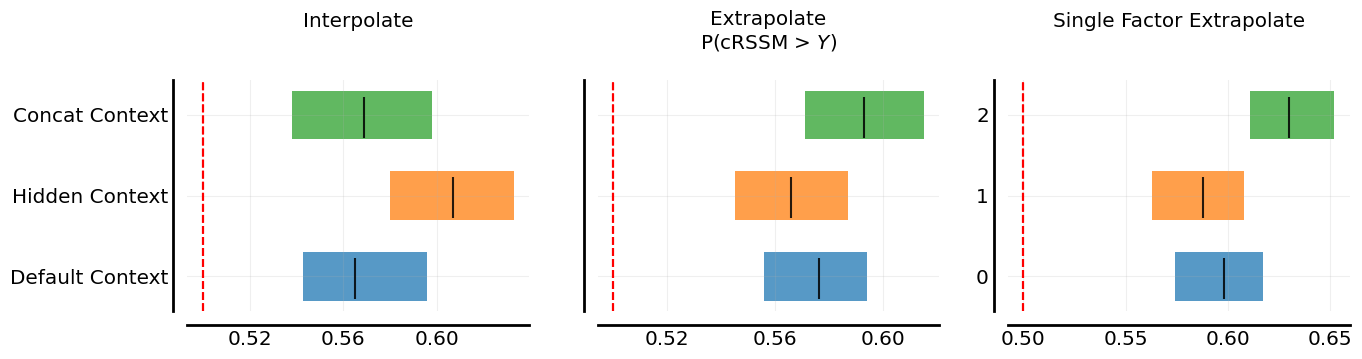

modality is: img
(3,) (3, 2)
['no_ctx_default', 'no_ctx', 'enc_dec_ctx'] pgm_ctx
(3,) (3, 2)
['no_ctx_default', 'no_ctx', 'enc_dec_ctx'] pgm_ctx
(3,) (3, 2)
['no_ctx_default', 'no_ctx', 'enc_dec_ctx'] pgm_ctx
0
pgm_ctx_no_ctx_default
1
pgm_ctx_no_ctx
2
pgm_ctx_enc_dec_ctx
0
pgm_ctx_no_ctx_default
1
pgm_ctx_no_ctx
2
pgm_ctx_enc_dec_ctx
0
pgm_ctx_no_ctx_default
1
pgm_ctx_no_ctx
2
pgm_ctx_enc_dec_ctx


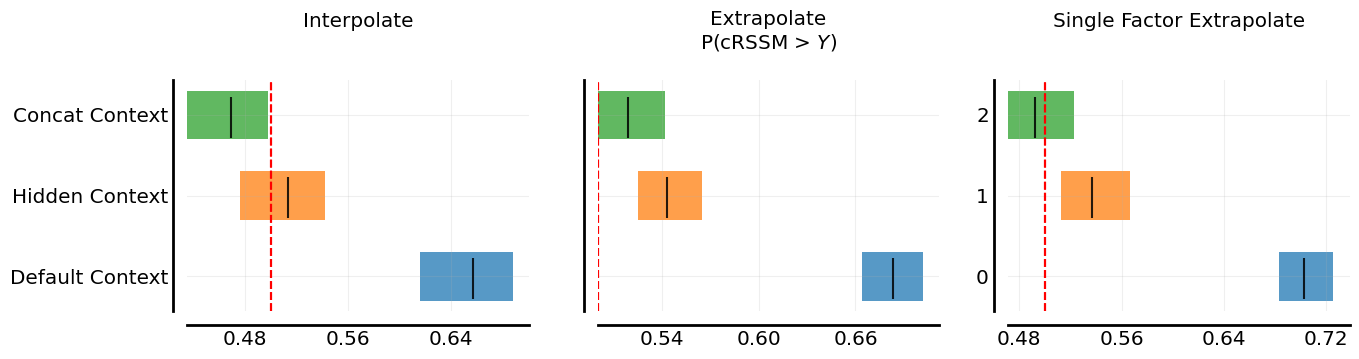

In [97]:
#algorithm_map = {'pgm_ctx': 'cRSSM', 'enc_dec_ctx': 'Concat Context', 'no_ctx': 'No Context', 'no_ctx_default': 'No Context Default'}
CTX_ALG_MAP_INV = {v: k for k, v in CTX_ALG_MAP.items()}
for name, subframe in df_agg.groupby(np.arange(len(df_agg)) // 4):
    #print(name)
    #print(group.head())
    #drop last row
    #get last row input name 
    our_alg = CTX_ALG_MAP_INV[subframe.loc[:, 'Inputs'].values[-1]]
    subframe = subframe[:-1]
    algorithms = subframe.loc[:, 'Inputs'].values
    algorithms = [CTX_ALG_MAP_INV[alg] for alg in algorithms]
    

    print(f"modality is: {modality}")
    probabilities = {}
    for key in ['Interp_IP', 'Extrap_IP', 'Inter_Extra_IP']:
        #type_map = {'Interp': 'Interpolate', 'Extrap': 'Extrapolate', 'Inter_Extra': 'Single Factor Extrapolate'}
        type_title = f'{TYPE_MAP[key[:-3]]}'
        ip_probs = subframe.loc[:, key].values
        ip_probs_ci = np.stack(list(subframe.loc[:, f'{key}_ci'].values))
        print(ip_probs.shape, ip_probs_ci.shape)
        print(algorithms, our_alg)
        #name pairs 
        alg_pairs = [f'{our_alg}_{alg}' for alg in algorithms if alg != our_alg]
        ip_probs = {alg_pair: prob for alg_pair, prob in zip(alg_pairs, ip_probs)}
        ip_probs_ci = {alg_pair: ci for alg_pair, ci in zip(alg_pairs, ip_probs_ci)}
        probabilities[type_title] = (ip_probs, ip_probs_ci)
        title = f'Aggregate - {modality} - {type_title}'
    
    plot_ip_all(probabilities, our_alg = 'pgm_ctx', title = title, target_dir = 'RLIBLE_PLOT_TEST_IP')



    

In [ ]:
for name, subframe in df_agg.groupby(np.arange(len(df_agg)) // 4):
    #print(name)
    #print(group.head())
    #drop last row
    subframe = subframe[:-1]

    algorithms = subframe.index
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #compute_IP_metric(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, random_agent_metrics, t_step="50k", our_algorithm = "pgm_ctx")
        for key in ['Interp_IP', 'Extrap_IP', 'Inter_Extra_IP']:
            type_map = {'Interp': 'Interpolate', 'Extrap': 'Extrapolate', 'Inter_Extra': 'Single Factor Extrapolate'}
            type_title = f'{type_map[key[:-3]]}'
            ip_probs = subframe.loc[:, key].values
            ip_probs_ci = np.stack(list(subframe.loc[:, f'{key}_ci'].values))
            #create dict from arrays
            

            title = f'{TASK_MAP[task]} - {context_label.capitalize()} - {"Featurized" if modality == "obs" else "Pixel"} - {type_title}'
            plot_ip(ip_probs, ip_probs_ci, our_alg = 'pgm_ctx', title = title)

                            